In [35]:
import importlib
import matplotlib.pyplot as plt
import numpy as np
import os, os.path
import pandas as pd
import pathlib
import sisepuede.core.support_classes as sc
import sisepuede.manager.sisepuede_file_structure as sfs
import sisepuede.manager.sisepuede_models as sm
import sisepuede.utilities._toolbox as sf
import utils.common_data_needs as cdn
import warnings
warnings.filterwarnings("ignore")

from typing import *



# Initialize some SISEPUEDE components

In [80]:
dict_ssp = cdn._setup_sisepuede_elements()

matt = dict_ssp.get("model_attributes", )
models = dict_ssp.get("models", )
regions = dict_ssp.get("regions", )
time_periods = dict_ssp.get("time_periods", )

# setup region
_REGION_NAME = "uganda"
_REGION_ISO = regions.return_region_or_iso(_REGION_NAME, return_type = "iso")

# LVST categories
_CAT_LVST_BUFFALO = "buffalo"
_CAT_LVST_CATTLE_DAIRY = "cattle_dairy"
_CAT_LVST_CATTLE_NONDAIRY = "cattle_nondairy"
_CAT_LVST_CHICKENS = "chickens"
_CAT_LVST_GOATS = "goats"
_CAT_LVST_HORSES = "horses"
_CAT_LVST_MULES = "mules"
_CAT_LVST_PIGS = "pigs"
_CAT_LVST_SHEEP = "sheep"

# some fields
_FIELD_HEADS_EXOTIC = "heads_exotic"
_FIELD_HEADS_INDIGENOUS = "heads_indigenous"
_FIELD_HEADS_TOTAL = "heads_total"
_FIELD_PERC_EXOTIC_BEEF = "perc_exotic_beef"
_FIELD_PERC_EXOTIC_DAIRY = "perc_exotic_dairy"
_FIELD_PERC_IND_ANKOLE = "perc_ind_ankole"
_FIELD_PERC_IND_ZEBU = "perc_ind_zebu"


##################################################
#    initialize a global dict for populations    #
##################################################

_ATTRIBUTE_TABLE_LVST = matt.get_attribute_table(matt.subsec_name_lvst, )
_DICT_POPS_2021_LIVESTOCK = dict(
    (x, 0) for x in _ATTRIBUTE_TABLE_LVST.key_values
)

# Use most recent livestock census to adjust livestock trajectories
- Uganda government numbers are taken from _NATIONAL LIVESTOCK CENSUS 2021 MAIN REPORT_
- For any data that are missing, existing trends present in FAO data are used

In [46]:
[x for x in dir(models.model_afolu) if "modvar_lvst" in x]


['modvar_lvst_adjusted_equivalent_exports',
 'modvar_lvst_adjusted_equivalent_imports',
 'modvar_lvst_animal_weight',
 'modvar_lvst_b0_manure_ch4',
 'modvar_lvst_carrying_capacity_scalar',
 'modvar_lvst_changes_to_net_imports_lost',
 'modvar_lvst_demand_livestock',
 'modvar_lvst_dry_matter_consumption',
 'modvar_lvst_ef_ch4_ef',
 'modvar_lvst_elas_lvst_demand',
 'modvar_lvst_emissions_ch4_ef',
 'modvar_lvst_equivalent_exports',
 'modvar_lvst_frac_demand_imported',
 'modvar_lvst_frac_exc_n_in_dung',
 'modvar_lvst_frac_mm_anaerobic_digester',
 'modvar_lvst_frac_mm_anaerobic_lagoon',
 'modvar_lvst_frac_mm_composting',
 'modvar_lvst_frac_mm_daily_spread',
 'modvar_lvst_frac_mm_deep_bedding',
 'modvar_lvst_frac_mm_dry_lot',
 'modvar_lvst_frac_mm_incineration',
 'modvar_lvst_frac_mm_liquid_slurry',
 'modvar_lvst_frac_mm_poultry_manure',
 'modvar_lvst_frac_mm_ppr',
 'modvar_lvst_frac_mm_solid_storage',
 'modvar_lvst_genfactor_nitrogen',
 'modvar_lvst_genfactor_volatile_solids',
 'modvar_lvst_

<Axes: xlabel='year'>

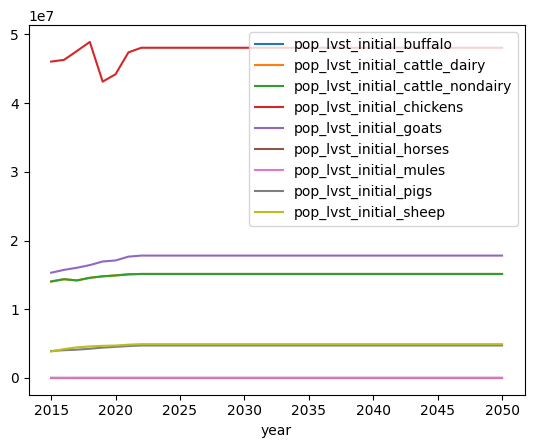

In [47]:
df_uganda = cdn.get_raw_ssp_inputs()

# get some SISEPUEDE info
attr_gnrl = matt.get_attribute_table(matt.subsec_name_gnrl)
modvar_pop = matt.get_variable(
    models.model_afolu.modvar_lvst_pop_init,
)


(
    modvar_pop
    .get_from_dataframe(
        df_uganda, 
        fields_additional = [time_periods.field_year],
    )
    .plot(x = time_periods.field_year, )
)


##  Get Cattle population info
- Table 3.2 (page 72)
- Assume that beef vs. dual use:
    - **Ankole** (see [Livestock Conservancy](https://livestockconservancy.org/ankole-watusi-cattle/#:~:text=Breed%20Facts,of%20their%20horns%20–%20was%20significant):
        - Weight between 900 and 1600 lbs
        - Both Beef and Dairy
            - Historically dairy ([Homestead on the Range](https://homesteadontherange.com/2013/10/09/ankole-watusi/#:~:text=Uses,are%20often%20used%20as%20decorations)), but appears to be changing, and it's unclear
            - Assume 50/50
    - **Zebu/Nganda** (see [FAO](https://openknowledge.fao.org/server/api/core/bitstreams/ee8e56b6-a520-4806-8d8c-62465ff18d0b/content/an470e07.pdf#:~:text=anda%20Protectorate%2C%201953.%20Functional%20characteristics%20of%20the,the%20production%20of%20both%20milk%20and%20beef.)):
        - Both dairy and beef, higher productivity than Ankole
        - Assumed weight 612 pounds (mean male/female, Table 89)


### Table in CSV matches this screenshot
![Cattle population distribtion, Table 3.2](input_data/ubos/livestock_survey_2021/ubos_lvst_survey_2021_table_3.2.png)

In [82]:
path_pop_cattle_2021 = cdn._PATH_INPUTS.joinpath("ubos", "livestock_survey_2021", "table_3_2_cattle_heads.csv")
df_cattle = pd.read_csv(path_pop_cattle_2021)

# defined from assumptions shown above from Livestock Conservancy (Ankole) and FAO (Nganda)
dict_breed_split_meat = {
    "ankole": 0.50,
    "zebu": 0.50,
}


def get_cattle_by_beef_dairy(
    df_cattle: pd.DataFrame,
    dict_breed_split: Dict[str, float],
) -> pd.DataFrame:
    """Estimate populations of beef/dairy cattle. Dual use breeds are 
        assumed to be split 50/50.
    """

    # copy existing df
    df_out = df_cattle.copy()

    fields_exotic = [_FIELD_PERC_EXOTIC_BEEF, _FIELD_PERC_EXOTIC_DAIRY]
    fields_indig = [_FIELD_PERC_IND_ANKOLE, _FIELD_PERC_IND_ZEBU]

    # verify as fractions that sum to 1
    df_out[fields_exotic] = sf.check_row_sums(
        df_out[fields_exotic]/100,
        thresh_correction = 1,
    )

    df_out[fields_indig] = sf.check_row_sums(
        df_out[fields_indig]/100,
        thresh_correction = 1,
    )


    ##  ESTIMATE BEEF VS DAIRY

    # initialize using exoting
    total_beef = (
        df_out[_FIELD_HEADS_EXOTIC].to_numpy()
        * df_out[_FIELD_PERC_EXOTIC_BEEF].to_numpy()
    ).sum()

    total_dairy = (
        df_out[_FIELD_HEADS_EXOTIC].to_numpy()
        * df_out[_FIELD_PERC_EXOTIC_DAIRY].to_numpy()
    ).sum()
    


    # adjust indigenous breeds
    for field in [
        _FIELD_PERC_IND_ANKOLE,
        _FIELD_PERC_IND_ZEBU
    ]:
        # init as none
        frac_beef = None

        # calculate current population by breed and then get the fraction that's beef
        vec_pop_cur = (
            df_out[_FIELD_HEADS_INDIGENOUS].to_numpy()
            * df_out[field].to_numpy()
        ).sum()
        
        for k, v in dict_breed_split.items():
            if k in field:
                frac_beef = v
                frac_dairy = 1 - v
                break

        total_beef += vec_pop_cur.sum()*frac_beef
        total_dairy += vec_pop_cur.sum()*frac_dairy


    out = (total_beef, total_dairy, )

    return out


pop_2021_cattle_beef, pop_2021_cattle_dairy = get_cattle_by_beef_dairy(
    df_cattle,
    dict_breed_split_meat,
)

_DICT_POPS_2021_LIVESTOCK.update(
    {
        _CAT_LVST_CATTLE_DAIRY: int(np.round(pop_2021_cattle_dairy)),
        _CAT_LVST_CATTLE_NONDAIRY: int(np.round(pop_2021_cattle_beef)),
    }
)

##  Get population information for goats


### Input data for goats matches Table 4.2a (only need total goat population)
![Goal population distribtion, Table 4.2a](input_data/ubos/livestock_survey_2021/ubos_lvst_survey_2021_table_4.2a.png)

In [83]:
pop_2021_goats = 17_358_355
_DICT_POPS_2021_LIVESTOCK.update(
    {
        _CAT_LVST_GOATS: pop_2021_goats,
    }
)

##  Get population information for sheep


### Input data for sheets matches Table 5.2a (only need total sheep population)
![Sheep population distribtion, Table 5.2a](input_data/ubos/livestock_survey_2021/ubos_lvst_survey_2021_table_5.2a.png)

In [84]:
pop_2021_sheep = 4_363_756
_DICT_POPS_2021_LIVESTOCK.update(
    {
        _CAT_LVST_SHEEP: pop_2021_sheep,
    }
)

##  Get population information for Pigs


### Input data for pigs matches Table 6.2 (only need total sheep population)
![Pig population distribtion, Table 6.2](input_data/ubos/livestock_survey_2021/ubos_lvst_survey_2021_table_6.2.png)

In [85]:
pop_2021_pigs = 7_083_943
_DICT_POPS_2021_LIVESTOCK.update(
    {
        _CAT_LVST_PIGS: pop_2021_pigs,
    }
)

##  Get population information for Chickens


### Input data for chickens matches Table 7.2a (only need total sheep population)
- **NOTE**: whole table is not shown here because we only need the total population for 2021, not by sub-breed.
![Chicken population distribtion, Table 7.2a](input_data/ubos/livestock_survey_2021/ubos_lvst_survey_2021_table_7.2a_part1.png)

In [86]:
pop_2021_chickens = 57_844_910
_DICT_POPS_2021_LIVESTOCK.update(
    {
        _CAT_LVST_CHICKENS: pop_2021_chickens,
    }
)

##  Get population information for Donkeys/Horses/Camels

- Place "donkeys" in "mules"
- Place "camels" in "horses"


### Input data for horses and mules matches Table 8.2 (only need total population for each category)

![Donkey and camel population distribtion, Table 7.2a](input_data/ubos/livestock_survey_2021/ubos_lvst_survey_2021_table_8.2.png)


In [87]:
pop_2021_camels = 12418
pop_2021_donkeys = 62827

_DICT_POPS_2021_LIVESTOCK.update(
    {
        _CAT_LVST_MULES: pop_2021_donkeys,
        _CAT_LVST_HORSES: pop_2021_camels,
    }
)

# Run this cell to check!

In [90]:
for k in _ATTRIBUTE_TABLE_LVST.key_values:
    pop = _DICT_POPS_2021_LIVESTOCK.get(k)

    if pop == 0:
        print(f"** WARNING!\tNo population (pop 0) found for livestock class {k}")
    else:
        print(f"Population of livestock class {k}: {pop}")

** WARNING!	No population (pop 0) found for livestock class buffalo
Population of livestock class cattle_dairy: 8577924
Population of livestock class cattle_nondairy: 5899909
Population of livestock class chickens: 57844910
Population of livestock class goats: 17358355
Population of livestock class horses: 12418
Population of livestock class mules: 62827
Population of livestock class pigs: 7083943
Population of livestock class sheep: 4363756
